# A Well-Conditioned Estimator For Large-Dimensional Covariance Matrices (Ledoit-Wolf 2004)

This notebook tries to reproduce the results about of the paper. It uses my custom implemenation of the Identity Shrinkage estimator defined, which has already been tested and matches perfectly the original MATLAB implementation.

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from covShrinkage.linear import IdentityShrinkage

The Monte Carlo framework developed to test the estimators is based on normally distributed data, with mean zero. The actual covariance matrix is also randomly generated; sampling its eigenvalues from a log normal distribution.

<hr>

The simulation studies the dynamics of the *Percentage Relative Improvement in Average Loss* $PRIAL$

$$
PRIAL = \frac{\mathbb{E}[\Vert \hat{S} - \Sigma \Vert^2] - \mathbb{E}[\Vert S^* - \Sigma \Vert^2]}{\mathbb{E}[\Vert \hat{S} - \Sigma \Vert^2]}
$$

There are three main parameters that affect the performarnce of the estimator
 - The ratio $p/n$, which we center around the value $\frac{1}{2}$
 - The eigenvalue dispersio $\alpha^2$, which we center around $\frac{1}{2}$
 - The product $pn$, which we center around $800$

 We run three different simulations, one for each of the parameters, where we keep two of them constants and let the other vary around its central value.


In [20]:
n_vals = np.array([200, 160, 100, 80, 50, 40, 32, 25, 20, 16, 10, 8, 5, 4])
p_vals = np.array([4, 5, 8, 10, 16, 20, 25, 32, 40, 50, 80, 100, 160, 200])
PRIALs = np.zeros(len(n_vals))

## 1. Dynamics with respect to the ratio $p/n$

We set the constants for this particular simulation: we'll average out $R = 1000$ scenarios, where eigenvalues of the true covariance matrix $\Sigma$ are sampled from a lognormal distribution of mean one and disperion is 

$$ \alpha^2 = \frac{1}{p}\sum_{k=1}^{p} (\lambda_k - \mu)^2$$

which we set to $0.5$. If $\lambda \sim \log \mathcal{N}(m,s^2)$, then

$$ 
    \mathbb{E}[\lambda] = e^{m + s^2/2} \\
    Var(\lambda) = (e^{s^2}-1) e^{2m+s^2}
$$

We enforce the mean to be one, which leads $ m = -\frac{s^2}{2}$, and the variance must be equal to $\alpha^2$, hence

$$
    \alpha^2 = e^{s^2}-1 \;\; \implies \;\; s^2 = \log(1+\alpha^2) 
$$

In [21]:
R = 1000              
alpha2 = 0.25 
s2 = np.log(1 + alpha2)
m  = -0.5 * s2

np.random.seed(0)

In [22]:
for i in range(len(n_vals)):
    n = n_vals[i]
    p = p_vals[i]
    
    lambdas = np.random.lognormal(mean=m, sigma=np.sqrt(s2), size=p)
    lambdas /= np.mean(lambdas)

    true_sigma = np.diag(lambdas)

    sample_err = 0.0
    identity_err = 0.0
    
    for _ in range(R):
        #Y = np.random.multivariate_normal(np.zeros(p), true_sigma, size=n)
        Z = np.random.normal(size=(n, p))
        Y = Z @ np.diag(np.sqrt(lambdas))

        Yc = Y - Y.mean(axis=0, keepdims=True)
        sample = (Yc.T @ Yc) / n

        S_star = IdentityShrinkage(assume_centered=True).fit(Yc)

        identity_sigmahat = S_star.covariance
        
        sample_err += np.linalg.norm(sample - true_sigma, ord='fro')**2
        identity_err += np.linalg.norm(identity_sigmahat - true_sigma, ord='fro')**2
    
    sample_err /= R
    identity_err /= R
    PRIALs[i] = 100 * (sample_err - identity_err) / sample_err

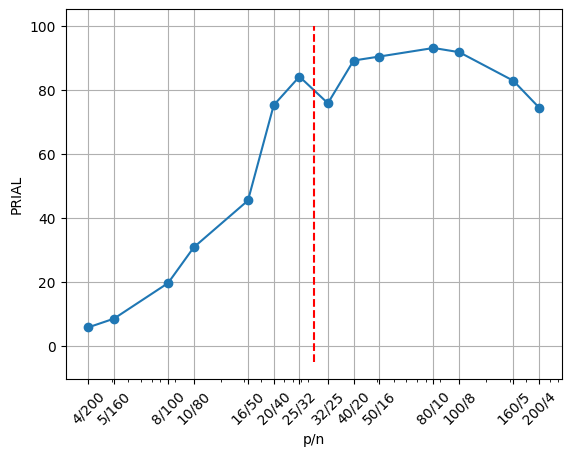

In [24]:
ticks = [p/n for n, p in zip(n_vals, p_vals, strict=False)]
labels = [f"{p}/{n}" for n, p in zip(n_vals, p_vals, strict=False)]

plt.semilogx(ticks, PRIALs, marker='o')
plt.xlabel('p/n')
plt.xticks(ticks=ticks, labels=labels, rotation=45)
plt.ylabel('PRIAL')
plt.grid()
plt.vlines(1, -5, 100, colors='r', linestyles='dashed')

## 2. Dynamics with respect to eigenvalue disperion $\alpha^2$

In [44]:
alphas = np.linspace(0.01, 1, 100)
n, p = 40, 20
PRIALs_alpha = np.zeros(len(alphas))

In [45]:
for i in range(len(alphas)):
    s2 = np.log(1 + alphas[i])
    m  = -0.5 * s2
    
    lambdas = np.random.lognormal(mean=m, sigma=np.sqrt(s2), size=p)
    lambdas /= np.mean(lambdas)

    true_sigma = np.diag(lambdas)

    sample_err = 0.0
    identity_err = 0.0
    
    for _ in range(R):
        #Y = np.random.multivariate_normal(np.zeros(p), true_sigma, size=n)
        Z = np.random.normal(size=(n, p))
        Y = Z @ np.diag(np.sqrt(lambdas))

        Yc = Y - Y.mean(axis=0, keepdims=True)
        sample = (Yc.T @ Yc) / n

        S_star = IdentityShrinkage(assume_centered=True).fit(Yc)

        identity_sigmahat = S_star.covariance
        
        sample_err += np.linalg.norm(sample - true_sigma, ord='fro')**2
        identity_err += np.linalg.norm(identity_sigmahat - true_sigma, ord='fro')**2
    
    sample_err /= R
    identity_err /= R
    PRIALs_alpha[i] = 100 * (sample_err - identity_err) / sample_err

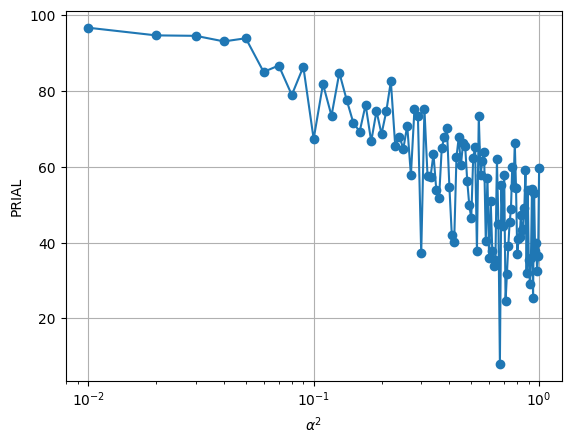

In [46]:
plt.semilogx(alphas, PRIALs_alpha, marker='o')
plt.xlabel(r'$\alpha^2$')
plt.ylabel('PRIAL')
plt.grid()

## 3. Dynamics with respect to the product $pn$

In [48]:
n_vals = np.array([6, 10, 30, 40, 50, 60, 70, 80])
p_vals = np.array([3, 5, 15, 20, 25, 30, 35, 40])

PRIALs_np = np.zeros(len(n))

alpha2 = 0.25 
s2 = np.log(1 + alpha2)
m  = -0.5 * s2

In [51]:
for i in range(len(n_vals)):
    n = n_vals[i]
    p = p_vals[i]
    
    lambdas = np.random.lognormal(mean=m, sigma=np.sqrt(s2), size=p)
    lambdas /= np.mean(lambdas)

    true_sigma = np.diag(lambdas)

    sample_err = 0.0
    identity_err = 0.0
    
    for _ in range(R):
        #Y = np.random.multivariate_normal(np.zeros(p), true_sigma, size=n)
        Z = np.random.normal(size=(n, p))
        Y = Z @ np.diag(np.sqrt(lambdas))

        Yc = Y - Y.mean(axis=0, keepdims=True)
        sample = (Yc.T @ Yc) / n

        S_star = IdentityShrinkage(assume_centered=True).fit(Yc)

        identity_sigmahat = S_star.covariance
        
        sample_err += np.linalg.norm(sample - true_sigma, ord='fro')**2
        identity_err += np.linalg.norm(identity_sigmahat - true_sigma, ord='fro')**2
    
    sample_err /= R
    identity_err /= R
    PRIALs_np[i] = 100 * (sample_err - identity_err) / sample_err

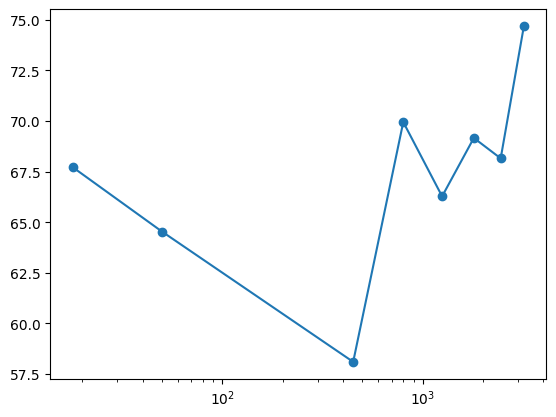

In [52]:
pn = [p*n for n, p in zip(n_vals, p_vals, strict=False)]
plt.semilogx(pn, PRIALs_np, marker='o')